# Neuropixels Visual Coding Tutorial

## Bernstein Workshop 2020: Leveraging Open Datasets from the Allen Brain Observatory for Computational Neuroscience

The Allen Institute has publicly released data from in vivo extracellular electrophysiology ("ecephys") experiments in awake mice viewing a variety of visual stimuli. This tutorial will teach you how to access and analyze this data using the AllenSDK, an open-source Python library. It assumes you have basic knowledge of Python and some familiarity with the types of data generated by electrophysiological recordings. 

The data from these experiments are organized into *sessions*, where each session is a distinct continuous recording period. During a session we collect:

- spike times and characteristics (such as mean waveforms) from up to 6 neuropixels probes
- local field potentials
- behavioral data, such as running speed and eye position
- visual stimuli which were presented during the session
- cell-type specific optogenetic stimuli that were applied during the session

The AllenSDK contains code for accessing across-session (project-level) metadata as well as code for accessing detailed within-session data. The standard workflow is to use project-level tools, such as `EcephysProjectCache` to identify and access sessions of interest, then delve into those sessions' data using `EcephysSession`.

This tutorial is divided into 5 parts:
* <a href='#Part-1:-Data-access'>Data access</a>
* <a href='#Part-2:-Reading-data-from-an-NWB-file'>Reading data from an NWB file</a>
* <a href='#Part-3:-Aligning-data-to-stimulus-presentations'>Aligning data to stimulus presentations</a>
* <a href='#Part-4:-Receptive-field-mapping'>Receptive field mapping</a>
* <a href='#Part-5:-Decoding-Natural-Images'>Decoding natural images</a>



# Part 1: Data access

If you're running analysis locally, the **`EcephysProjectCache` object of the AllenSDK** is the easiest way to retrieve the data. This object abstracts away the details of on-disk file storage, and delivers the data to you as ready-to-analyze Python objects. The cache will automatically keep track of which files are stored locally, and will download additional files on an as-needed basis.

In this tutorial, we'll be using  account, we'll use an `EcephysProjectCache` object to access the data via the **Amazon Web Services (AWS)** Allen Brain Observatory Simple Storage Service (S3) bucket. This is an AWS Public Dataset located at `arn:aws:s3:::allen-brain-observatory` in region `us-west-2`. Launching a Jupyter notebook instance on AWS will allow you to access the complete dataset without having to download anything locally. This includes around 80 TB of raw data files, which are not accessible via the AllenSDK.

For a more detailed looked at data access, check out [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_data_access.html).

## Using the AllenSDK to retrieve data

To get started with this approach, first take care of the necessary imports:

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

Before downloading the data, you must decide where the `manifest.json` file lives. This file serves as the map that guides the `EcephysProjectCache` object to the file locations.

When you initialize a local cache for the first time, it will create the manifest file at the path that you specify. This file lives in the same directory as the rest of the data, so make sure you put it somewhere that has enough space available. If you want to download the complete dataset (58 experiments), you'll need 855 GB of space, split across the following files:

1. CSV files containing information about sessions, probes, channels and units (58.1 MB)
2. NWB files containing spike times, behavior data, and stimulus information for each session (146.5 GB total, min file size = 1.7 GB, max file size = 3.3 GB)
3. NWB files containing LFP data for each probe (707 GB total, min file size = 0.9 GB, max file size = 2.7 GB)

When you need to access the data in subsequent analysis sessions, you should point the `EcephysProjectCache` object to an _existing_ `manifest.json` file; otherwise, it will try to re-download the data in a new location.

Since we're using AWS for this demonstration, we'll point to the existing manifest on the Allen Institute's S3 bucket: 

In [2]:
data_directory = '/mnt/nvme0/ecephys_cache_dir_2' 

manifest_path = os.path.join(data_directory, "manifest.json")

Now we can create the cache object, specifying both the local storage directory (the `manifest_path`) and the remote storage location (the Allen Institute data warehouse).

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

This will prepare the cache to download four files:

1. `sessions.csv` (7.8 kB)
2. `probes.csv` (27.0 kB)
3. `channels.csv` (6.6 MB)
4. `units.csv` (51.4 MB)

Each one contains a table of information related to its file name. If you're using the AllenSDK, you won't have to worry about how these files are formatted. Instead, you'll load the relevant data using specific accessor functions: `get_session_table()`, `get_probes()`, `get_channels()`, and `get_units()`. These functions return a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html?highlight=dataframe) containing a row for each item and a column for each metric.

Let's take a closer look at what's in the `sessions.csv` file:

In [4]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


The `sessions` DataFrame provides a high-level overview of the Neuropixels Visual Coding dataset. The index column is a unique ID, which serves as a key for accessing the physiology data for each session. The other columns contain information about:

- the session type (i.e., which stimulus set was shown?)
- the age, sex, and genotype of the mouse (in this dataset, there's only one session per mouse)
- the number of probes, channels, and units for each session
- the brain structures recorded (CCFv3 acronyms)

If we want to find all of recordings from male Sst-Cre mice that viewed the Brain Observatory 1.1 stimulus and contain units from area LM, we can use the following query:

In [5]:
filtered_sessions = sessions[(sessions.sex == 'M') & \
                             (sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISl' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

filtered_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


The `filtered_sessions` table contains the three sessions that meet these criteria.

The code above uses standard syntax for filtering pandas DataFrames. If this is unfamiliar to you, we strongly recommend reading through the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/). The AllenSDK makes heavy use of pandas objects, so we don't have to come up with our own functions for working with tabular data.

Let's take a look at another DataFrame, extracted from the `probes.csv` file.

In [6]:
probes = cache.get_probes()

print('Total number of probes: ' + str(len(probes)))

probes.head()

Total number of probes: 332


,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,unit_count,channel_count,ecephys_structure_acronyms
id,,,,,,,,,
729445648,719161530,1249.998642,probeA,3a,29999.967418,True,87,374,"[APN, LP, MB, DG, CA1, VISam, nan]"
729445650,719161530,1249.996620,probeB,3a,29999.918880,True,202,368,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]"
729445652,719161530,1249.999897,probeC,3a,29999.997521,True,207,373,"[APN, NOT, MB, DG, SUB, VISp, nan]"
729445654,719161530,1249.996707,probeD,3a,29999.920963,True,93,358,"[grey, VL, CA3, CA2, CA1, VISl, nan]"
729445656,719161530,1249.999979,probeE,3a,29999.999500,True,138,370,"[PO, VPM, TH, LP, LGd, CA3, DG, CA1, VISal, nan]"


The `probes` DataFrame contains information about the Neuropixels probes used across all recordings. Each row represents one probe from one recording session, even though the physical probes may have been used in multiple sessions. Some of the important columns are:

- `ecephys_session_id`: the index column of the `sessions` table
- `sampling_rate`: the sampling rate (in Hz) for this probe's spike band; note that each probe has a unique sampling rate around 30 kHz. The small variations in sampling rate across probes can add up to large offsets over time, so it's critical to take these differences into account. However, all of the data you will interact with has been pre-aligned to a common clock, so this value is included only for reference purposes.
- `lfp_sampling_rate`: the sampling rate (in Hz) for this probe's LFP band NWB files, after 2x downsampling from the original rate of 2.5 kHz
- `name`: the probe name is assigned based on the location of the probe on the recording rig. This is useful to keep in mind because probes with the same name are always targeted to the same cortical region and enter the brain from the same angle (`probeA` = AM, `probeB` = PM, `probeC` = V1, `probeD` = LM, `probeE` = AL, `probeF` = RL). However, the targeting is not always accurate, so the actual recorded region may be different.
- `phase`: the data may have been generated by one of two "phases" of Neuropixels probes. **3a** = prototype version; **PXI** = publicly available version ("Neuropixels 1.0"). The two phases should be equivalent from the perspective of data analysis, but there may be differences in the noise characteristics between the two acquisition systems.
- `channel_count`: the number of channels with spikes or LFP data (maximum = 384)

The `channels.csv` file contains information about each of these channels.

In [7]:
channels = cache.get_channels()

print('Total number of channels: ' + str(len(channels)))

channels.head()

Total number of channels: 123224


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
849705558,792645504,1,11,20,8165.0,3314.0,6862.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705560,792645504,2,59,40,8162.0,3307.0,6866.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705562,792645504,3,27,40,8160.0,3301.0,6871.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705564,792645504,4,43,60,8157.0,3295.0,6875.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705566,792645504,5,11,60,8155.0,3288.0,6879.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0


The most important columns in the `channels` DataFrame concern each channel's location in physical space. Each channel is associated with a location along the probe shank (`probe_horizontal_position` and `probe_vertical_position`), and may be linked to a coordinate in the Allen Common Coordinate framework (if CCF registration is available for that probe).

The information about channel location will be merged into the `units` DataFrame, which is loaded from `units.csv`:

In [8]:
units = cache.get_units()

print('Total number of units: ' + str(len(units)))

Total number of units: 40010


This DataFrame contains metadata about the available units across all sessions. By default, the AllenSDK applies some filters to this table and only returns units above a particular quality threshold.

The default filter values are as follows:

- `isi_violations` < 0.5
- `amplitude_cutoff` < 0.1
- `presence_ratio` > 0.95

For more information about these quality metrics and how to interpret them, please refer to [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html).

If you want to see _all_ of the available units, it's straightfoward to disable the quality metrics filters when retrieving this table: 

In [9]:
units = cache.get_units(amplitude_cutoff_maximum = np.inf,
                        presence_ratio_minimum = -np.inf,
                        isi_violations_maximum = np.inf)

print('Total number of units: ' + str(len(units)))

Total number of units: 99180


As you can see, the number of units has increased substantially, but some fraction of these units will be incomplete or highly contaminated. Understanding the meaning of these metrics is a critical part of analyzing the Neuropixels dataset, so we strongly recommend learning how to interpret them correctly.

Let's look at the location of all of these units within the CCF, to get a sense of the areas that this dataset covers:

Text(7000, -3200, 'thalamus')

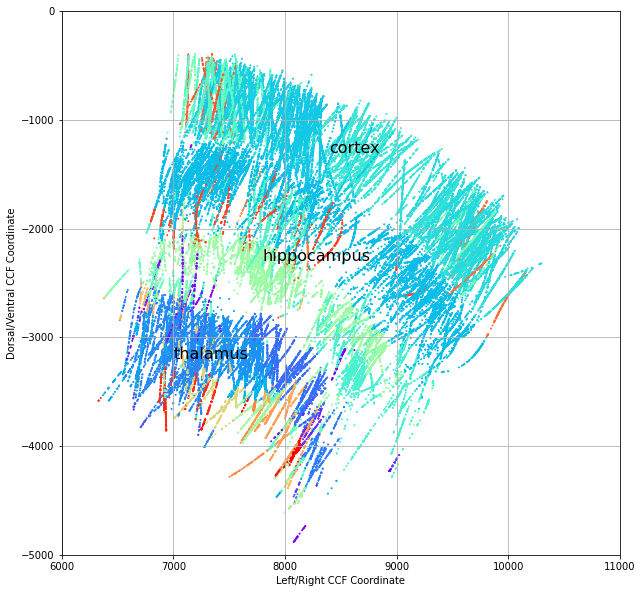

In [10]:
structure_ids = units.ecephys_structure_id
valid_structure_ids = np.invert(np.isnan(structure_ids))
all_structure_ids, labels = np.unique(units.ecephys_structure_id[valid_structure_ids], return_inverse=True)
lr_coords = units.left_right_ccf_coordinate[valid_structure_ids]
dv_coords = units.dorsal_ventral_ccf_coordinate[valid_structure_ids]

plt.figure(figsize=(10,10))
plt.scatter(lr_coords, -dv_coords, s=1, c=labels, cmap='rainbow')
plt.xlim([6000,11000])
plt.ylim([-5000,0])
plt.xlabel('Left/Right CCF Coordinate')
plt.ylabel('Dorsal/Ventral CCF Coordinate')
plt.grid('on')

plt.text(8400,-1300, 'cortex', fontsize=16)
plt.text(7800,-2300, 'hippocampus', fontsize=16)
plt.text(7000,-3200, 'thalamus', fontsize=16)

The above plot shows the location of all units, viewed in a coronal section looking from the front of the brain. You can see stripes for the cortex, hippocampus, and thalamus.

# Part 2: Reading data from an NWB file

We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. Calling `get_session_data` on your `EcephysProjectCache` will download such a file and return an `EcephysSession` object.

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

Let's look at a file from one of the sessions we selected earlier. If you're accessing the data on your local machine, it may take some time to download the full dataset (approximately 2.6 GB):

In [11]:
session_id = filtered_sessions.index.values[2]

session = cache.get_session_data(session_id)

## Spike times and waveforms

First, we'll learn how to explore the available units in this dataset, and look at their spike times and waveforms. 

Information about the recorded units is available in the `session.units` DataFrame:

In [12]:
units = session.units

print('Total number of units: ' + str(len(units)))

units.head()

Total number of units: 684


,L_ratio,presence_ratio,d_prime,waveform_halfwidth,cluster_id,firing_rate,peak_channel_id,silhouette_score,waveform_repolarization_slope,waveform_amplitude,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951814884,0.024771,0.99,3.555518,0.096147,6,9.492176,850126382,0.033776,0.673650,187.434780,...,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814876,0.001785,0.99,4.445414,0.206030,5,39.100557,850126382,0.108908,0.518633,129.686505,...,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815032,0.035654,0.99,3.848256,0.096147,17,28.383277,850126398,0.096715,0.766347,207.380940,...,215.0,APN,8129.0,3419.0,6762.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815275,0.016783,0.99,3.065938,0.096147,30,5.709358,850126416,0.144249,0.628944,158.158650,...,215.0,APN,8095.0,3349.0,6787.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815314,0.009666,0.99,4.198612,0.123618,34,23.902235,850126420,0.111106,0.740222,173.475705,...,215.0,APN,8088.0,3333.0,6792.0,probeA,See electrode locations,29999.949611,1249.9979,True


This table contains a variety of helpful metrics for each unit, such as its firing rate, waveform_amplitude, and CCF structure (`ecephys_structure_acronym`). There are also sorting quality metrics, such as `isi_violations`, `amplitude_cutoff`, and `presence_ratio`. Let's begin by selecting all the units in V1 (`VISp`) that have a low ISI violations score (an indication of low contamination levels):

In [13]:
V1_units = units[(units.ecephys_structure_acronym == 'VISp') &
                (units.isi_violations < 0.1)]

print('Total number of low-contamination V1 units: ' + str(len(V1_units)))

Total number of low-contamination V1 units: 35


We will use the index column of this table (labeled `unit_id`) to extract the data for individual units, such as their spike times and waveforms. 

To retrieve the spike times for one unit as a `numpy` array, simply call `session.spike_times[unit_id]`:

In [14]:
unit_id = V1_units.index.values[0]

session.spike_times[unit_id]

/home/joshs/anaconda3/envs/bernstein-tutorial/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


array([4.38972776e+00, 4.95332954e+00, 5.66793179e+00, ...,
       9.96473648e+03, 9.96522671e+03, 9.96535038e+03])

Depending on the session you're analyzing, you may see a warning about invalid time intervals. The default session (`756029989`) does have some invalid times, which can result from interruptions in data acquisition or problems with the stimulus display. We've chosen to release sessions with some invalid intervals, in order to salvage the data. To see the intervals (and reasons for invalidation), just type `session.invalid_times`:

In [15]:
session.invalid_times

,start_time,stop_time,tags
id,,,
0,7675.15,7692.68,"[EcephysProbe, 760640097, probeE]"


Here, we see that Probe E is missing data between 7675 and 7692 seconds. If you're analyzing this section of the data, this will explain why there's a gap, which is not due to the fact that all units were silent on this probe.

We store precomputed mean waveforms for each unit in the `mean_waveforms` attribute on the `EcephysSession` object. This is a dictionary which maps unit ids to xarray [DataArrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html). These have `channel` and `time` (seconds, aligned to the detected event times) dimensions. The data values are in microvolts, as measured at the recording site.

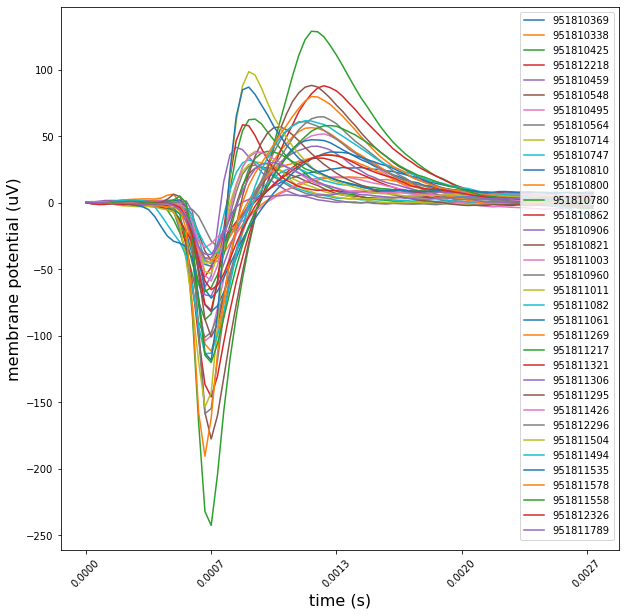

In [16]:
units_of_interest = V1_units.index.values

waveforms = {uid: session.mean_waveforms[uid] for uid in units_of_interest}
peak_channels = {uid: session.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest}

# plot the mean waveform on each unit's peak channel/
plot_mean_waveforms(waveforms, units_of_interest, peak_channels)
plt.show()

This plot only includes the peak channel waveform for each unit, but the NWB file contains the waveform across the entire probe, allowing you to analyze how it propagates along the probe axis.

## Stimulus presentation times

Next, we'll look at how to access information about the visual stimuli that were presented.

`session.stimulus_names` will show the stimuli that are available in this session:

In [17]:
session.stimulus_names

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

To access the stimulus table for a particular stimulus type, use the following code:

In [18]:
stim_table = session.get_stimulus_table(['drifting_gratings'])

stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1585.734418,2,drifting_gratings,1587.736098,2,2.00168,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1588.736891,2,drifting_gratings,1590.738571,2,2.00168,247
3800,0.8,180,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1591.739398,2,drifting_gratings,1593.741078,2,2.00168,246
3801,0.8,270,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1594.741921,2,drifting_gratings,1596.743591,2,2.00167,248
3802,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1597.744458,2,drifting_gratings,1599.746088,4,2.00163,249


This shows us the parameters for each stimulus presentation (trial), indexed by a unique stimulus presentation ID.

## Behavioral data

We can obtain the velocity at which the experimental subject ran as a function of time by accessing the `running_speed` attribute. This returns a pandas dataframe whose rows are intervals of time (defined by "start_time" and "end_time" columns), and whose "velocity" column contains mean running speeds within those intervals.

Here we'll plot the running speed trace for an arbitrary chunk of time.

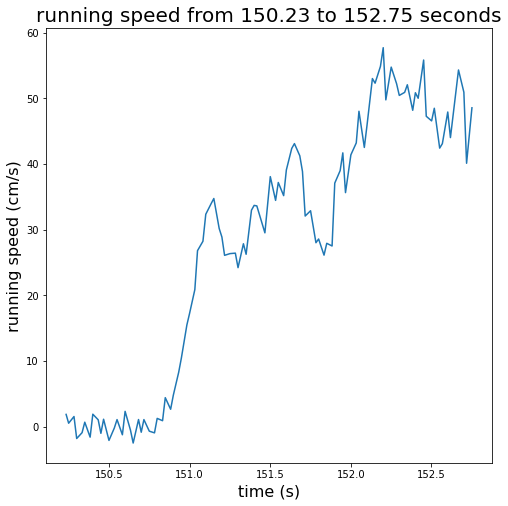

In [19]:
plot_running_speed(
    session.running_speed["start_time"], 
    session.running_speed["velocity"], 
    start_index=5000,
    stop_index=5100
)

plt.show()

To obtain information about where the animal was looking on the screen, we can call `session.get_screen_gaze_data()`

In [20]:
gaze_data = session.get_screen_gaze_data()
gaze_data.head()

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.20620,0.072246,0.008627,3.192181,0.863288,11.996034,3.294251
3.22948,0.072116,0.008734,3.103325,0.916339,11.669031,3.496204
3.23714,0.072292,0.008807,3.116553,0.919020,11.717276,3.506406
3.27028,0.072347,0.008060,3.107700,1.061316,11.677819,4.047634
3.30396,0.072026,0.008814,3.285226,0.929605,12.331983,3.546691


This table also contains information about the pupil area, which we can plot over time:

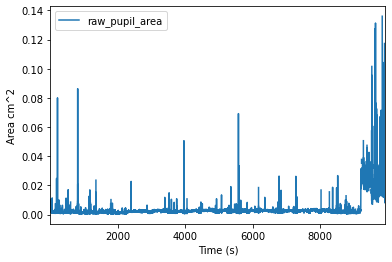

In [21]:
ax = gaze_data[["raw_pupil_area"]].plot()
_ = ax.set_ylabel("Area cm^2")

## LFP data

LFP, which stands for "local field potential," contains information about low-frequency (0.1-500 Hz) voltage fluctations around each recording site. It's complementary to the spiking activity, and can be analyzed on its own or in conjunction with spikes.

LFP data is accessed on a probe-by-probe basis. Because the LFP data files are so large, they must be downloaded separately from the session NWBs.

Let's take a look at the probes that are available for this session:

In [22]:
session.probes

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
760640083,probeA,See electrode locations,29999.949611,1249.997900,True
760640087,probeB,See electrode locations,29999.902541,1249.995939,True
760640090,probeC,See electrode locations,29999.905275,1249.996053,True
760640094,probeD,See electrode locations,29999.905275,1249.996053,True
760640097,probeE,See electrode locations,29999.985335,1249.999389,True
760640104,probeF,See electrode locations,30000.023099,1250.000962,True


Let's look at the structures each of these probes passes through:

In [23]:
{session.probes.loc[probe_id].description : 
     list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
     for probe_id in session.probes.index.values}

{'probeA': [nan, 'APN', 'DG', 'CA1', 'VISam'],
 'probeB': ['VISpm', nan, 'LP', 'DG', 'CA1', 'PO', 'Eth'],
 'probeC': ['VISp', nan, 'POL', 'APN', 'MB', 'SCig', 'POST', 'SUB'],
 'probeD': ['VISl', nan, 'TH', 'DG', 'CA3', 'CA1'],
 'probeE': [nan, 'VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal'],
 'probeF': [nan, 'DG', 'CA1', 'VISrl']}

Let's choose one and load its associated LFP data:

In [24]:
probe_id = session.probes[session.probes.description == 'probeE'].index.values[0]

lfp = session.get_lfp(probe_id)

If you haven't tried to access this data previously, you'll have to wait while the LFP NWB file downloads. Even if you already have the data stored locally, it may still take a minute to load, since the LFP data is quite large.

Once the data is loaded, we can take a closer look at the `lfp` object:

In [25]:
lfp

<xarray.DataArray 'LFP' (time: 12412150, channel: 94)>
array([[ 2.00849991e-05,  3.47099995e-05,  2.55449995e-05, ...,
         0.00000000e+00, -1.55999999e-06, -3.70499993e-06],
       [ 4.52399981e-05,  6.76650016e-05, -1.20899995e-05, ...,
        -3.50999994e-06, -8.58000021e-06, -1.94999998e-07],
       [ 1.03350003e-05, -9.75000034e-07, -6.04499983e-05, ...,
        -1.17000002e-06, -1.55999999e-06,  6.23999995e-06],
       ...,
       [ 1.72575004e-04,  1.43130004e-04,  9.55500000e-05, ...,
         5.85000009e-07,  8.96999973e-06,  1.22849997e-05],
       [ 1.78425005e-04,  1.78620001e-04,  1.31819994e-04, ...,
         3.50999994e-06,  8.77499951e-06,  1.36500003e-05],
       [ 9.65250001e-05,  1.07834996e-04,  6.25949979e-05, ...,
         2.73000001e-06,  2.14500005e-06,  5.84999998e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 3.776 3.777 3.777 ... 9.95e+03 9.95e+03 9.95e+03
  * channel  (channel) int64 850123698 850123706 ... 850124434 850124442

The LFP data is stored as an [xarray.DataArray](http://xarray.pydata.org/en/stable/) object, with coordinates of `time` and `channel`. The xarray library simplifies the process of working with N-dimensional data arrays, by keeping track of the meaning of each axis. If this is your first time encountering xarrays, we strongly recommend reading through the [documentation](http://xarray.pydata.org/en/stable/quick-overview.html) before going further. Getting used to xarrays can be frustrating, especially when they don't behave like numpy arrays. But they are designed to prevent common mistakes when analyzing multidimensional arrays, so they are well worth learning more about. Plus, the syntax is modeled on that of the [pandas](https://pandas.pydata.org/) library, so if you're familiar with that you already have a head start.

The print-out above already tells us a lot about what the `lfp` object contains. It stores an array with around 12 million points along the `time` axis and 95 points along the `channel` axis. The `time` axis ranges from 13.5 to around 9600 seconds, while the `channel` axis ranges from 850258492 to 850259244 (these are the unique IDs for each channel).

Let's use the `DataArray.sel()` method to select a slice through this array between 100 and 101 seconds:

In [26]:
lfp_slice = lfp.sel(time=slice(100,101))

lfp_slice

<xarray.DataArray 'LFP' (time: 1250, channel: 94)>
array([[-1.9110001e-05, -1.1895000e-05,  2.5350000e-06, ...,
         5.4600000e-06, -2.5740001e-05, -5.0700000e-06],
       [-4.6800001e-06, -3.8415001e-05, -1.3065000e-05, ...,
         3.3150000e-06, -2.0474999e-05, -9.7500003e-07],
       [-4.3874999e-05, -4.9334998e-05, -4.2899999e-05, ...,
         4.0949999e-06, -1.2870000e-05,  9.7500003e-07],
       ...,
       [ 3.8999999e-05,  3.3540000e-05,  1.5015000e-05, ...,
        -3.3150000e-06, -1.5600000e-06,  1.5600000e-06],
       [ 4.6019999e-05,  2.0670001e-05,  6.0645001e-05, ...,
        -7.6050001e-06,  0.0000000e+00,  6.0449997e-06],
       [ 6.4155000e-05,  5.1675001e-05,  4.4460001e-05, ...,
        -1.3650000e-06,  4.4849999e-06,  6.6299999e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 100.0 100.0 100.0 100.0 ... 101.0 101.0 101.0 101.0
  * channel  (channel) int64 850123698 850123706 ... 850124434 850124442

We see that this new DataArray is smaller than before; it contains the same number of channels, but only 1250 samples, due to the LFP sample rate of ~1250 Hz.

Let's plot the data for one of the channels:

Text(0, 0.5, 'LFP (V)')

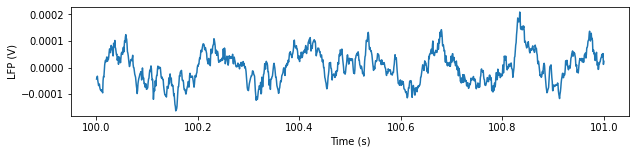

In [27]:
plt.figure(figsize=(10,2))
_ = plt.plot(lfp_slice.time, lfp_slice.sel(channel=lfp_slice.channel[10]))
plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

Alternatively, we can visualize this slice  of data using matplotlib's `imshow` method:

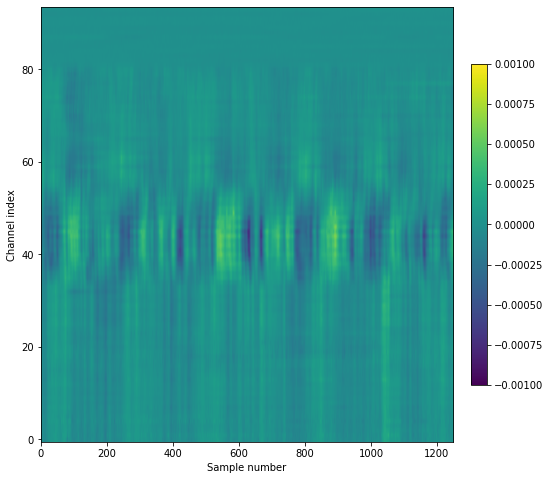

In [28]:
plt.figure(figsize=(8,8))
im = plt.imshow(lfp_slice.T,aspect='auto',origin='lower',vmin=-1e-3, vmax=1e-3)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

Note that we've transposed the original array to place the time dimension along the x-axis. We've also configured the plot so that the origin of the array is in the lower-left, so that that channels closer to the probe tip are lower in the image.

A few things to note about this plot:

* The units of the LFP are volts, so the color scale ranges from -1 to +1 mV
* Even though there are 384 channels on the Neuropixels probe, there are only 95 channels in this plot. That's because only every 4th channel is included in the NWB file (resulting in 40 micron vertical spacing). In addition, the reference channels and channels far outside the brain have been removed.
* The top of the plot is relatively flat. This corresponds to channels that are outside the brain. The LFP channels are originally referenced to a ground wire embedded in the ACSF/agarose mixture about cortex. Before NWB packaging, the LFP data is digitally referenced to the channels outside the brain, to remove noise that's shared across the whole probe.
* There's a large increase in LFP power toward the middle of the probe, which corresponds to channels in hippocampus.

Now it's time to do some more interesting analysis by aligning spikes and LFP to stimulus times!

## Part 3: Aligning data to stimulus presentations

Accessing the raw spike times and LFP is all well and good, but most analyses require some form of stimulus alignment. This section will show you how to do that!

First we need to select some trials to use. Let's use full-field flashes (gray-to-black or gray-to-white):

In [29]:
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'flashes']

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

### Spike times

In [31]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=units_of_interest
)

times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1585.741621,3798,951811321,0.007203
1585.748054,3798,951811011,0.013636
1585.757954,3798,951810862,0.023536
1585.775521,3798,951810747,0.041103
1585.779021,3798,951810714,0.044603


Plot a raster of these times:

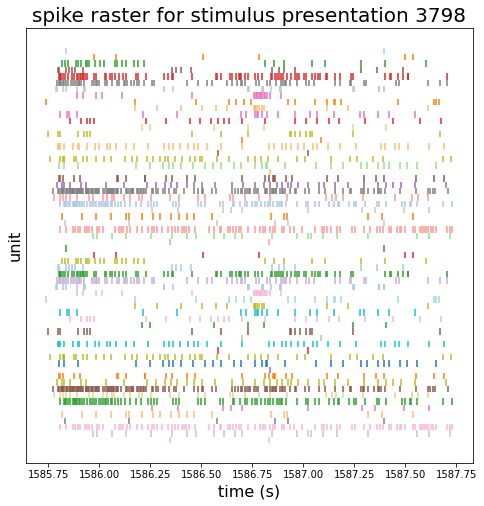

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           180
phase                    [42471.86666667, 42471.86666667]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1585.73
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1587.74
temporal_frequency                                      2
x_position                                           null
y_position                                           null
duration                                          2.00168
stimulus_condition_id                                 246
Name: 3798, dtype: object

In [32]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

### Binned spike times

It is commonly useful to compare spike data from across units and stimulus presentations, all relative to the onset of a stimulus presentation. We can do this using the `presentationwise_spike_counts` method. 

In [33]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

# look at responses to the flash stimulus
flash_250_ms_stimulus_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session.units[
    session.units['snr'] >= 1.5
].index.values

spike_counts_da = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=units_of_interest
)
spike_counts_da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 199, unit_id: 35)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951810369 ... 951811789

his has returned a new (to this notebook) data structure, the `xarray.DataArray`. You can think of this as similar to a 3+D `pandas.DataFrame`, or as a `numpy.ndarray` with labeled axes and indices. See the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more information. In the mean time, the salient features are:

- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and coordinates, improving readability and avoiding bugs. However, you can always convert to numpy or pandas data structures as follows:
- to pandas: `spike_counts_ds.to_dataframe()` produces a multiindexed dataframe
- to numpy: `spike_counts_ds.values` gives you access to the underlying numpy array

We can now plot spike counts for a particular presentation:

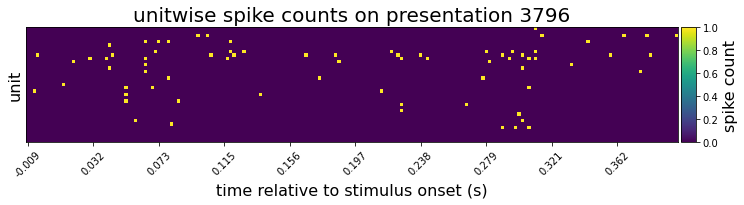

In [34]:
presentation_id = 3796 # chosen arbitrarily
plot_spike_counts(
    spike_counts_da.loc[{'stimulus_presentation_id': presentation_id}], 
    spike_counts_da['time_relative_to_stimulus_onset'],
    'spike count', 
    f'unitwise spike counts on presentation {presentation_id}'
)
plt.show()

We can also average across all presentations, adding a new data array to the dataset. Notice that this one no longer has a stimulus_presentation_id dimension, as we have collapsed it by averaging.

In [35]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199, unit_id: 35)>
array([[0.        , 0.00666667, 0.        , ..., 0.        , 0.        ,
        0.00666667],
       [0.01333333, 0.        , 0.00666667, ..., 0.00666667, 0.        ,
        0.        ],
       [0.00666667, 0.00666667, 0.01333333, ..., 0.01333333, 0.        ,
        0.02666667],
       ...,
       [0.00666667, 0.        , 0.01333333, ..., 0.        , 0.        ,
        0.00666667],
       [0.01333333, 0.        , 0.04      , ..., 0.        , 0.        ,
        0.00666667],
       [0.01333333, 0.        , 0.04      , ..., 0.        , 0.        ,
        0.01333333]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951810369 ... 951811789

... and plot the mean spike counts:

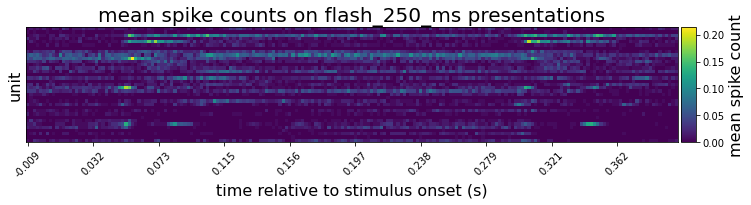

In [36]:
plot_spike_counts(
    mean_spike_counts, 
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash_250_ms presentations'
)
plt.show()

### LFP

Now, we can align the LFP to these presentation times using some xarray magic:

In [37]:
trial_window = np.arange(-0.5, 0.5, 1/500)
time_selection = np.concatenate([trial_window + t for t in presentation_times])

inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                  names=('presentation_id', 'time_from_presentation_onset'))

ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
ds = ds.assign(time=inds).unstack('time')

aligned_lfp = ds['aligned_lfp']

`aligned_lfp` is a DataArray with dimensions of channels x trials x time. It's been downsampled to 500 Hz by changing the time step in the `trial_window` variable.

Because we're using xarrays, the alignment operation is fast, and doesn't require any `for` loops! There's a lot going on here, so we recommend referring to the pandas and xarray documentation if anything is confusing.

Now we can visualize the average LFP, aligned to the trial onset:

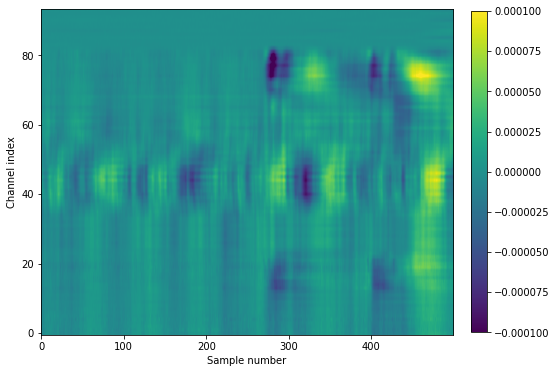

In [38]:
plt.figure(figsize=(8,6))
im = plt.imshow(aligned_lfp.mean(dim='presentation_id'), aspect='auto', origin='lower', vmin=-1e-4, vmax=1e-4)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

Here we see the effect of a 250 ms flash stimulus on the LFP. There are two large responses in cortex (channel index 60-80), one corresponding to the stimulus onset (around sample 280), and one corresponding to the stimulus offset (around sample 400).

Note that the voltage range is an order of magnitude less than it was for the single-trial LFP, around -100 to +100 microvolts.

You can use the code sample above to align the LFP to any type of event (e.g. spike times, running onset, optogenetic stimuli) just by changing the `trial_window` and `time_selection` variables.

## Part 4: Receptive field mapping

Because receptive field analysis is so central to interpreting results related to visual coding, every experiment in the Neuropixels Visual Coding dataset includes a standardized receptive field mapping stimulus. This stimulus is always shown at the beginning of the session, and uses the same parameters for every mouse. 

We can look at the `stimulus_presentations` DataFrame in order to examine the parameters of the receptive field mapping stimulus in more detail. The receptive field mapping stimulus consists of drifting Gabor patches with a circular mask, so we're going to filter the DataFrame based on `stimulus_name == 'gabors'`:

In [39]:
rf_stim_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'gabors']

len(rf_stim_table)

3645

There are 3645 trials for the receptive field mapping stimulus. What combination of stimulus parameters is used across these trials? Let's see which parameters actually vary for this stimulus:

In [40]:
keys = rf_stim_table.keys()
[key for key in keys if len(np.unique(rf_stim_table[key])) > 1]

['orientation',
 'start_time',
 'stop_time',
 'x_position',
 'y_position',
 'duration',
 'stimulus_condition_id']

We can ignore the parameters related to stimulus timing (`start_time`, `stop_time`, and `duration`), as well as `stimulus_condition_id`, which is used to find presentations with the same parameters. So we're left with `orientation`, `x_position`, and `y_position`.

In [41]:
print('Unique orientations : ' + str(list(np.sort(rf_stim_table.orientation.unique()))))
print('Unique x positions : ' + str(list(np.sort(rf_stim_table.x_position.unique()))))
print('Unique y positions : ' + str(list(np.sort(rf_stim_table.y_position.unique()))))

Unique orientations : [0.0, 45.0, 90.0]
Unique x positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]
Unique y positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]


What about the drifting grating parameters that don't vary, such as size (in degrees), spatial frequency (in cycles/degree), temporal frequency (in Hz), and contrast?

In [42]:
print('Spatial frequency: ' + str(rf_stim_table.spatial_frequency.unique()[0]))
print('Temporal frequency: ' + str(rf_stim_table.temporal_frequency.unique()[0]))
print('Size: ' + str(rf_stim_table['size'].unique()[0]))
print('Contrast: ' + str(rf_stim_table['contrast'].unique()[0]))

Spatial frequency: 0.08
Temporal frequency: 4.0
Size: [20.0, 20.0]
Contrast: 0.8


In order to visualize receptive fields, we're going to use a function in the `ReceptiveFieldMapping` class, one of the stimulus-specific analysis classes in the AllenSDK. Let's import it and create a `rf_mapping` object based on the `session` we loaded earlier:

In [43]:
from allensdk.brain_observatory.ecephys.stimulus_analysis.receptive_field_mapping import ReceptiveFieldMapping

rf_mapping = ReceptiveFieldMapping(session)

Let's use the same V1 units we extracted previously.

Calculating the receptive field is as simple as calling `get_receptive_field()` with a unit ID as the input argument.

In [44]:
RF = rf_mapping.get_receptive_field(V1_units.index.values[3])

/home/joshs/anaconda3/envs/bernstein-tutorial/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:644: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(0, 1)], with a maximum overlap of 0.015484041324228315 seconds.
  warnings.warn(f"You've specified some overlapping time intervals between neighboring rows: {overlapping}, "


This method creates a 2D histogram of spike counts at all 81 possible stimulus locations, and outputs it as a 9 x 9 matrix. It's summing over all orientations, so each pixel contains the spike count across 45 trials.
 
To plot it, just display it as an image. The matrix is already in the correct orientation so that it matches the layout of the screen (e.g., the upper right pixel contains the spike count when the Gabor patch was in the upper right of the screen).

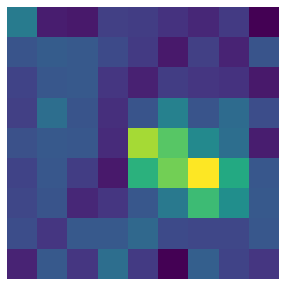

In [45]:
plt.figure(figsize=(5,5))
_ = plt.imshow(RF)
_ = plt.axis('off')

This particular unit has a receptive field that's more or less in the center of the screen.

Let's plot the receptive fields for all the units in V1:

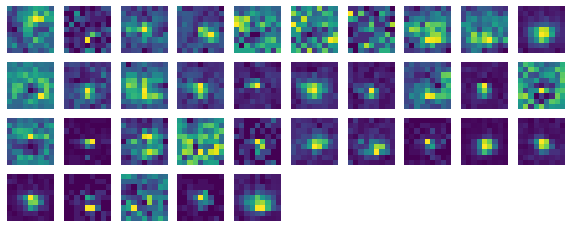

In [47]:
def plot_rf(unit_id, index):
    RF = rf_mapping.get_receptive_field(unit_id)
    _ = plt.subplot(6,10,index+1)
    _ = plt.imshow(RF)
    _ = plt.axis('off')
    
_ = plt.figure(figsize=(10,6))
_ = [plot_rf(RF, index) for index, RF in enumerate(V1_units.index.values)]

We have also pre-computed the RF locations for every cell. Going back to our original units table...

Why do we care about RFs? Cross-area interactions are influenced by the degree of receptive field overlap.

## Part 5: Decoding Natural Images

Interesting application: decoding Natural Images!

In [48]:
scene_presentations = session.get_stimulus_table("natural_scenes")
visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]

spikes = session.presentationwise_spike_times(
    stimulus_presentation_ids=scene_presentations.index.values,
    unit_ids=visp_units.index.values[:]
)

spikes

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5909.367606,51355,951810564,0.002208
5909.375006,51355,951810780,0.009608
5909.376406,51355,951811227,0.011008
5909.377206,51355,951810459,0.011808
5909.378406,51355,951811321,0.013008
...,...,...,...
8569.076638,68228,951810906,0.238150
8569.079838,68228,951810392,0.241350
8569.080138,68228,951810800,0.241650


Next, we will convert these into a num_presentations X num_units matrix, which will serve as our input data.

In [49]:
spikes["count"] = np.zeros(spikes.shape[0])
spikes = spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

design = pd.pivot_table(
    spikes, 
    values="count", 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
)

design

unit_id,951810314,951810338,951810369,951810392,951810425,951810459,951810495,951810517,951810548,951810564,...,951811546,951811558,951811578,951811646,951811778,951811789,951812218,951812284,951812296,951812326
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,
51355,0,4,1,1,13,9,10,5,3,30,...,0,0,0,0,2,14,7,1,1,0
51356,0,5,1,2,14,7,12,3,1,22,...,0,1,0,1,1,13,6,0,0,1
51357,0,2,2,0,8,2,11,0,2,8,...,0,1,0,1,1,10,10,1,0,0
51358,1,3,2,1,1,5,1,0,0,10,...,1,0,2,0,1,9,4,0,0,0
51359,0,8,5,0,2,3,2,0,2,9,...,0,0,0,0,2,13,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,1,6,0,1,8,4,0,0,0,5,...,0,0,0,0,4,2,0,0,0,0
68225,1,5,0,1,9,2,1,0,0,18,...,2,0,5,1,4,4,0,1,0,0
68226,0,1,1,1,7,5,3,0,3,9,...,0,0,0,1,1,0,1,0,0,1


... with targets being the numeric identifiers of the images presented.

In [50]:
targets = scene_presentations.loc[design.index.values, "frame"]
targets

stimulus_presentation_id
51355     95
51356     87
51357     72
51358     41
51359      9
        ... 
68224     81
68225     17
68226    113
68227     59
68228     98
Name: frame, Length: 5950, dtype: object

We'll use scikit-learn to do the prediction

In [51]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [52]:
design_arr = design.values.astype(float)
targets_arr = targets.values.astype(int)

labels = np.unique(targets_arr)

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5).split(design_arr):
    
    clf = svm.SVC(gamma="scale", kernel="rbf")
    clf.fit(design_arr[train_indices], targets_arr[train_indices])
    
    test_targets = targets_arr[test_indices]
    test_predictions = clf.predict(design_arr[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=labels))
    
print(f"mean accuracy: {np.mean(accuracy)}")
print(f"chance: {1/labels.size}")

0.36722689075630255
0.35462184873949576
0.3890756302521008
0.4403361344537815
0.23697478991596643
mean accuracy: 0.23697478991596643
chance: 0.008403361344537815


###### imagewise performance

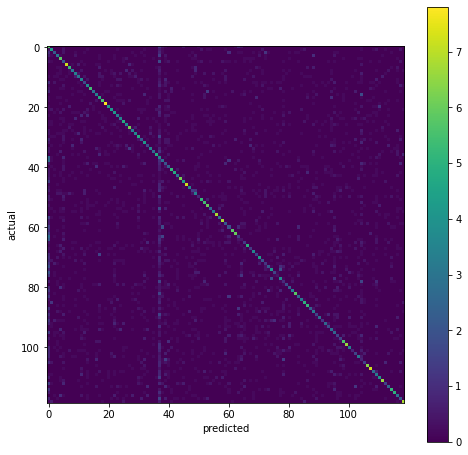

In [53]:
mean_confusion = np.mean(confusions, axis=0)

fig, ax = plt.subplots(figsize=(8, 8))

img = ax.imshow(mean_confusion)
fig.colorbar(img)

ax.set_ylabel("actual")
ax.set_xlabel("predicted")

plt.show()

Let's look at the most decodable and least decodable image

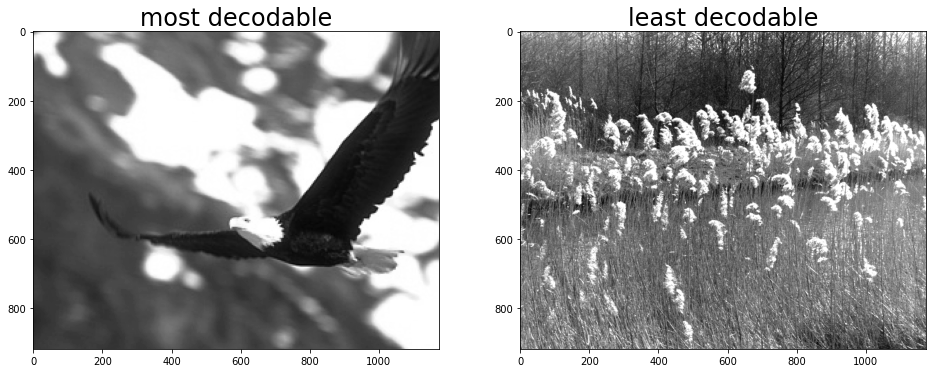

In [54]:
best = labels[np.argmax(np.diag(mean_confusion))]
worst = labels[np.argmin(np.diag(mean_confusion))]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

best_image = cache.get_natural_scene_template(best)
ax[0].imshow(best_image, cmap=plt.cm.gray)
ax[0].set_title("most decodable", fontsize=24)

worst_image = cache.get_natural_scene_template(worst)
ax[1].imshow(worst_image, cmap=plt.cm.gray)
ax[1].set_title("least decodable", fontsize=24)


plt.show()

Conclusion and future directions!